# Stripline analysis

This example shows how to use PyAEDT to create a differential stripline design in
2D Extractor and run a simulation.

Keywords: **Q2D**, **Stripline**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.generic.constants import MatrixOperationsQ2D


Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT and 2D Extractor

Launch AEDT 2025.2 in graphical mode and launch 2D Extractor. This example
uses SI units.

In [4]:
q2d = ansys.aedt.core.Q2d(
    project=os.path.join(temp_folder.name, "stripline"),
    design="differential_stripline",
    version=AEDT_VERSION,
    non_graphical=False,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_38f916c6-eea8-4fae-b582-2efd95ba9079.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 2628.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project stripline has been created.


PyAEDT INFO: Added design 'differential_stripline' of type 2D Extractor.


PyAEDT INFO: Aedt Objects correctly read


## Define variables

Define variables.

In [5]:
e_factor = "e_factor"
sig_w = "sig_bot_w"
sig_gap = "sig_gap"
co_gnd_w = "gnd_w"
clearance = "clearance"
cond_h = "cond_h"
core_h = "core_h"
pp_h = "pp_h"

for var_name, var_value in {
    "e_factor": "2",
    "sig_bot_w": "150um",
    "sig_gap": "150um",
    "gnd_w": "500um",
    "clearance": "150um",
    "cond_h": "17um",
    "core_h": "150um",
    "pp_h": "150um",
}.items():
    q2d[var_name] = var_value

delta_w_half = "({0}/{1})".format(cond_h, e_factor)
sig_top_w = "({1}-{0}*2)".format(delta_w_half, sig_w)
co_gnd_top_w = "({1}-{0}*2)".format(delta_w_half, co_gnd_w)
model_w = "{}*2+{}*2+{}*2+{}".format(co_gnd_w, clearance, sig_w, sig_gap)

## Create primitives

Create primitives and define the layer heights.

In [6]:
layer_1_lh = 0
layer_1_uh = cond_h
layer_2_lh = layer_1_uh + "+" + core_h
layer_2_uh = layer_2_lh + "+" + cond_h
layer_3_lh = layer_2_uh + "+" + pp_h
layer_3_uh = layer_3_lh + "+" + cond_h

## Create positive signal

Create a positive signal.

In [7]:
signal_p_1 = q2d.modeler.create_polyline(points=[[0, layer_2_lh, 0], [sig_w, layer_2_lh, 0]], name="signal_p_1")

PyAEDT INFO: Modeler2D class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


In [8]:
signal_p_2 = q2d.modeler.create_polyline(points=[[0, layer_2_uh, 0], [sig_top_w, layer_2_uh, 0]], name="signal_p_2")
q2d.modeler.move([signal_p_2], [delta_w_half, 0, 0])
q2d.modeler.connect([signal_p_1, signal_p_2])
q2d.modeler.move(assignment=[signal_p_1], vector=["{}+{}".format(co_gnd_w, clearance), 0, 0])

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Connection Correctly created


True

## Create negative signal

Create a negative signal.

In [9]:
signal_n_1 = q2d.modeler.create_polyline(points=[[0, layer_2_lh, 0], [sig_w, layer_2_lh, 0]], name="signal_n_1")

In [10]:
signal_n_2 = q2d.modeler.create_polyline(points=[[0, layer_2_uh, 0], [sig_top_w, layer_2_uh, 0]], name="signal_n_2")

In [11]:
q2d.modeler.move(assignment=[signal_n_2], vector=[delta_w_half, 0, 0])
q2d.modeler.connect([signal_n_1, signal_n_2])
q2d.modeler.move(
    assignment=[signal_n_1],
    vector=["{}+{}+{}+{}".format(co_gnd_w, clearance, sig_w, sig_gap), 0, 0],
)

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Connection Correctly created


True

## Create reference ground plane

Create a reference ground plane.

In [12]:
ref_gnd_u = q2d.modeler.create_rectangle(origin=[0, layer_1_lh, 0], sizes=[model_w, cond_h], name="ref_gnd_u")
ref_gnd_l = q2d.modeler.create_rectangle(origin=[0, layer_3_lh, 0], sizes=[model_w, cond_h], name="ref_gnd_l")

## Create dielectric

Create a dielectric.

In [13]:
q2d.modeler.create_rectangle(
    origin=[0, layer_1_uh, 0],
    sizes=[model_w, core_h],
    name="Core",
    material="FR4_epoxy",
)
q2d.modeler.create_rectangle(
    origin=[0, layer_2_uh, 0],
    sizes=[model_w, pp_h],
    name="Prepreg",
    material="FR4_epoxy",
)
q2d.modeler.create_rectangle(
    origin=[0, layer_2_lh, 0],
    sizes=[model_w, cond_h],
    name="Filling",
    material="FR4_epoxy",
)

Filling

## Assign conductors

Assign conductors to the signal.

In [14]:
q2d.assign_single_conductor(
    name=signal_p_1.name,
    assignment=[signal_p_1],
    conductor_type="SignalLine",
    solve_option="SolveOnBoundary",
    units="mm",
)

q2d.assign_single_conductor(
    name=signal_n_1.name,
    assignment=[signal_n_1],
    conductor_type="SignalLine",
    solve_option="SolveOnBoundary",
    units="mm",
)

PyAEDT INFO: Boundary SignalLine signal_p_1 has been created.


PyAEDT INFO: Boundary SignalLine signal_n_1 has been created.


signal_n_1

## Create reference ground

Create a reference ground.

In [15]:
q2d.assign_single_conductor(
    name="gnd",
    assignment=[ref_gnd_u, ref_gnd_l],
    conductor_type="ReferenceGround",
    solve_option="SolveOnBoundary",
    units="mm",
)

PyAEDT INFO: Boundary ReferenceGround gnd has been created.


gnd

## Assign Huray model on signals

Assign the Huray model on the signals.

In [16]:
q2d.assign_huray_finitecond_to_edges(signal_p_1.edges, radius="0.5um", ratio=3, name="b_" + signal_p_1.name)

q2d.assign_huray_finitecond_to_edges(signal_n_1.edges, radius="0.5um", ratio=3, name="b_" + signal_n_1.name)

PyAEDT INFO: Boundary Finite Conductivity b_signal_p_1 has been created.


PyAEDT INFO: Boundary Finite Conductivity b_signal_n_1 has been created.


b_signal_n_1

## Define differential pair

Define the differential pair.

In [17]:
matrix = q2d.insert_reduced_matrix(
    operation_name=MatrixOperationsQ2D.DiffPair,
    assignment=["signal_p_1", "signal_n_1"],
    reduced_matrix="diff_pair",
)

## Create setup, analyze, and plot

Create a setup, analyze, and plot solution data.

Create a setup.

In [18]:
setup = q2d.create_setup(name="new_setup")

Add a sweep.

In [19]:
sweep = setup.add_sweep(name="sweep1", sweep_type="Discrete")
sweep.props["RangeType"] = "LinearStep"
sweep.props["RangeStart"] = "1GHz"
sweep.props["RangeStep"] = "100MHz"
sweep.props["RangeEnd"] = "5GHz"
sweep.props["SaveFields"] = False
sweep.props["SaveRadFields"] = False
sweep.props["Type"] = "Interpolating"
sweep.update()

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpjdw4e_mp.ansys\stripline.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpjdw4e_mp.ansys\stripline.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015964031219482422


True

Analyze the nominal design and plot characteristic impedance.

In [20]:
q2d.analyze(cores=NUM_CORES)
plot_sources = matrix.get_sources_for_plot(category="Z0")

PyAEDT INFO: Project stripline Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/2D Extractor correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 20.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/2D Extractor correctly changed.


Get simulation results as a ``SolutionData`` object and plot to a JPG file.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpjdw4e_mp.ansys\stripline.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpjdw4e_mp.ansys\stripline.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.031407833099365234


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.016030311584472656
Time to initialize solution data:0.03195977210998535


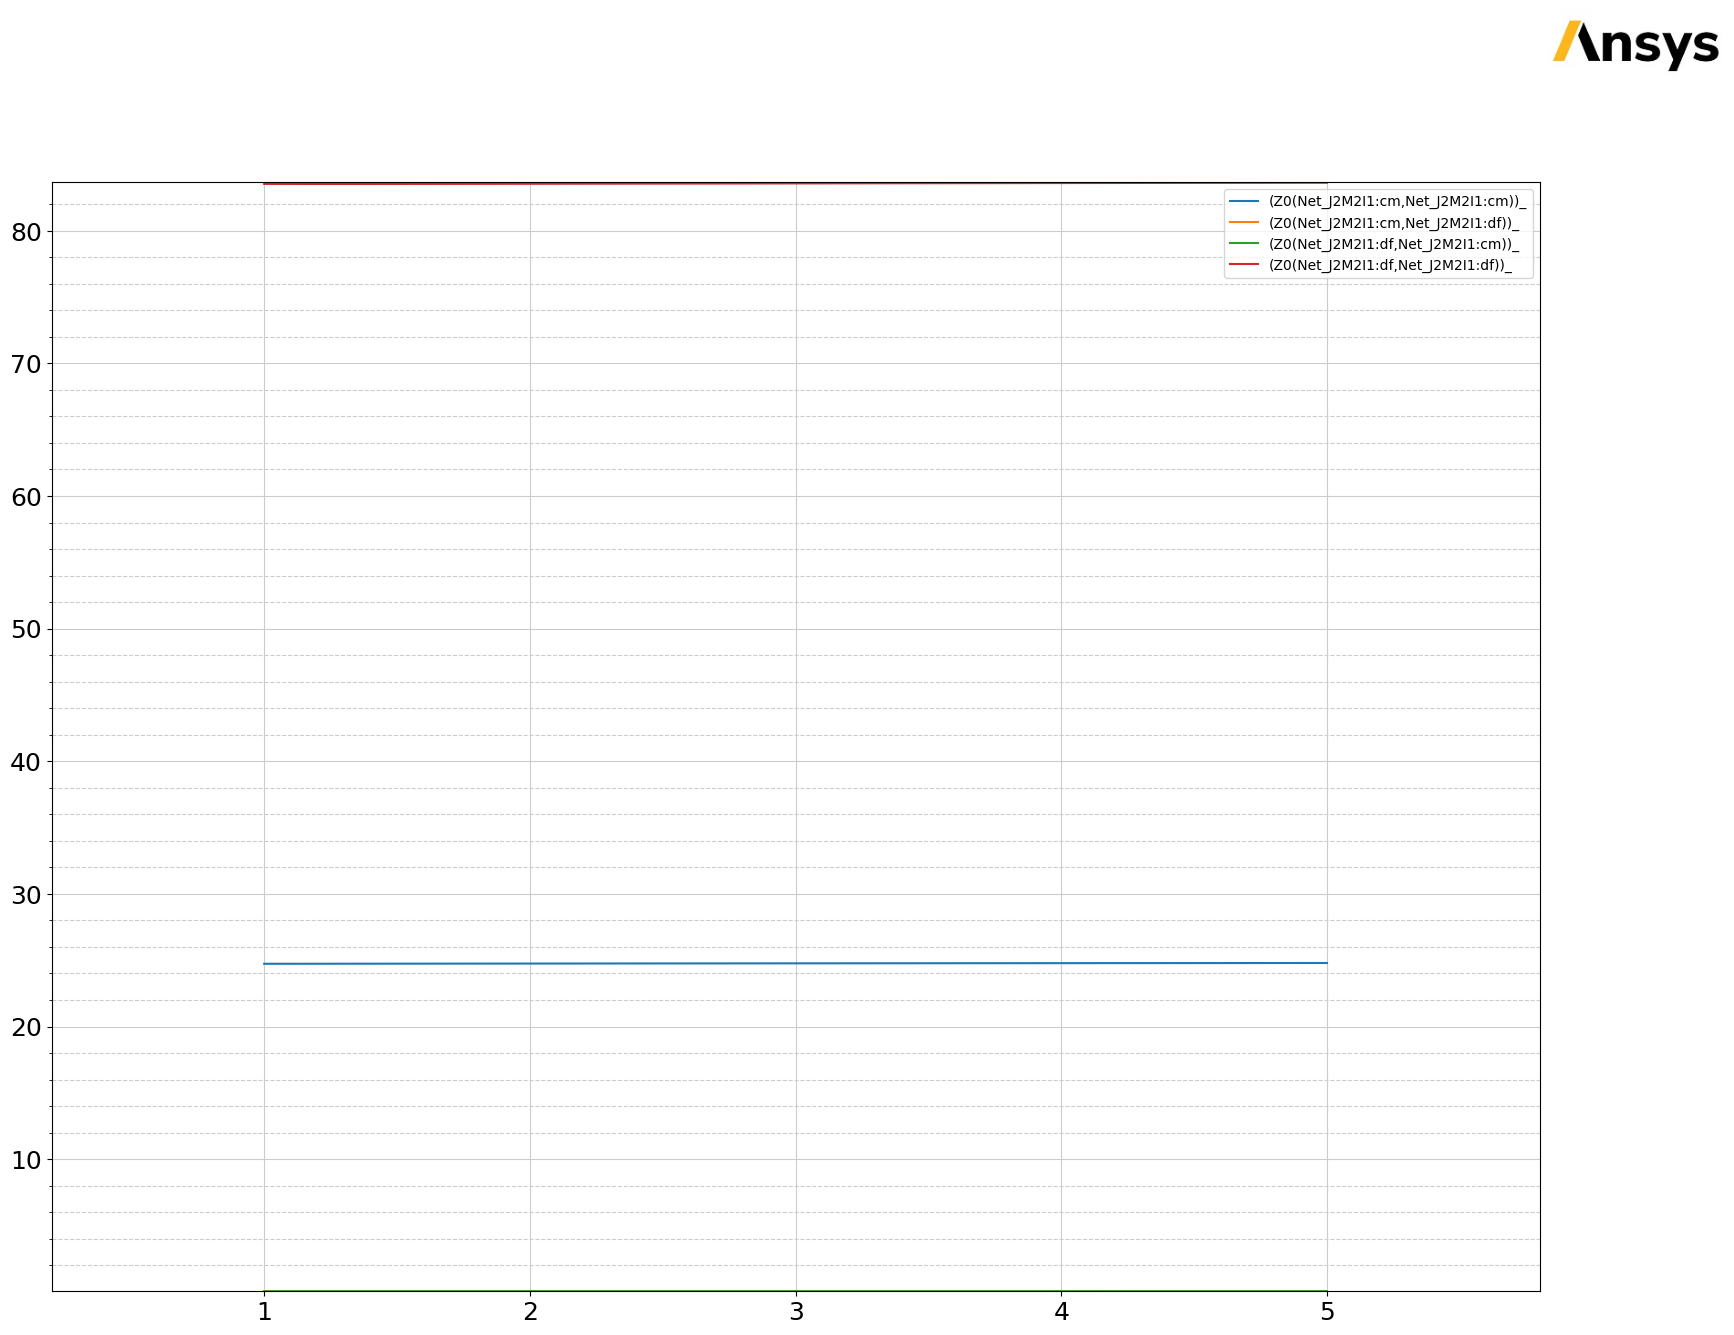

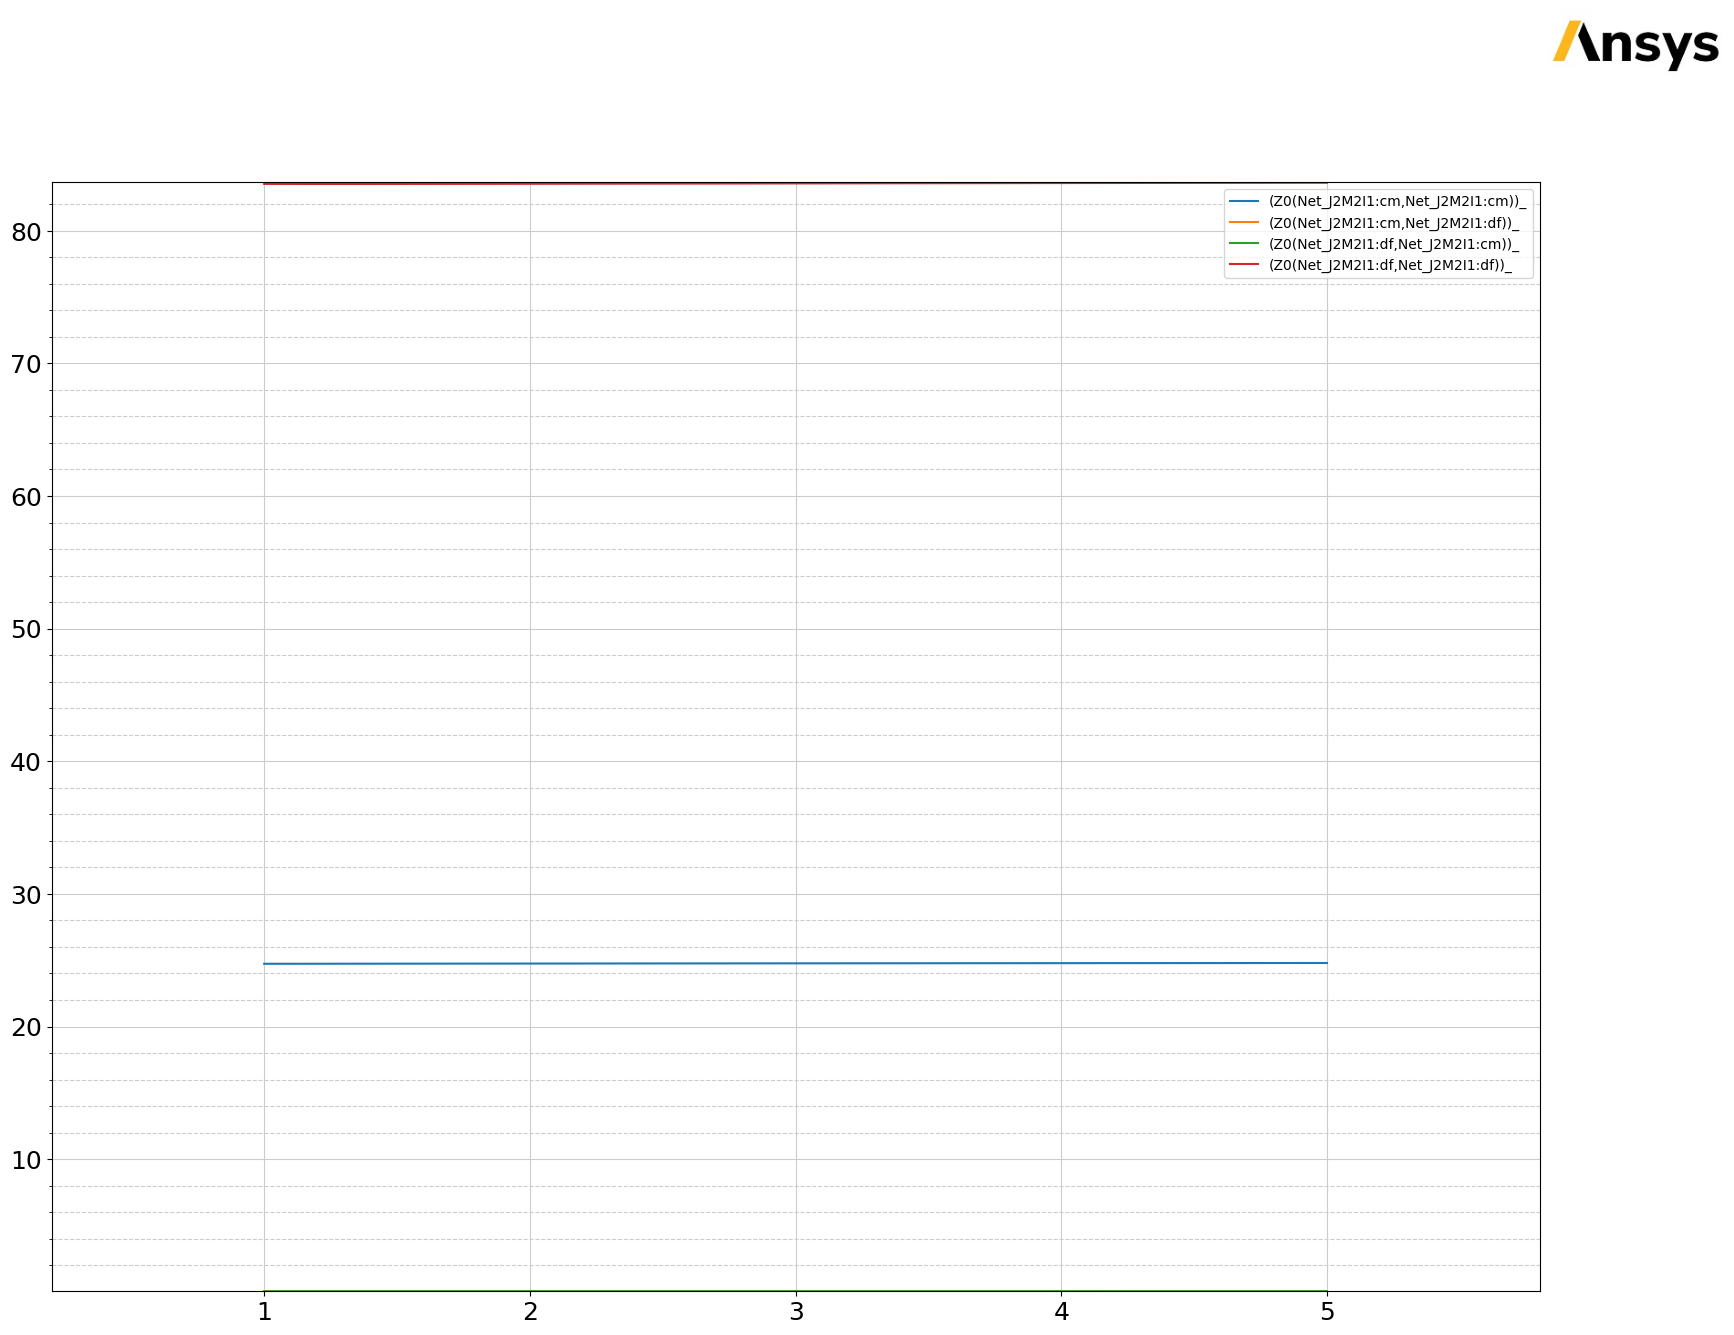

In [21]:
data = q2d.post.get_solution_data(expressions=plot_sources, context=matrix.name)
data.plot(snapshot_path=os.path.join(temp_folder.name, "plot.jpg"))

-

## Release AEDT

In [22]:
q2d.save_project()
q2d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project stripline Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [23]:
temp_folder.cleanup()